<a href="https://colab.research.google.com/github/saquibali7/MultiModalHateSpeeechDetection/blob/main/HateSpeechDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import cv2
import pytesseract
import shutil
import random
from pytesseract import pytesseract
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torchvision.models as models
import torchtext
import transformers
from transformers import AutoModel, BertTokenizerFast
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
HateSpeech = "/content/drive/MyDrive/hateSpeechDetection/Hate Speech"
NoHateSpeech = "/content/drive/MyDrive/hateSpeechDetection/No Hate Speech"


In [5]:
HateImages = os.listdir(HateSpeech)
NotHateImages = os.listdir(NoHateSpeech)
print(len(HateImages), len(NotHateImages))

1942 1658


In [6]:
def extract_text(path):
  image_path=path
  extractedInformation = pytesseract.image_to_string(Image.open(image_path))
  return extractedInformation



Zelensky demanded seven billion dollars
of financial assistance per month
ria.ru/20220414/ukrai...

 

8:51 PM - 14 Apr 22 - TweetDeck

23 Retweets 24 Quote Tweets 22 Likes

ZELENSKY CAN GO F*** HIMSELF
7 BILLION TIMES PER MONTH

I'M SURE LIBTARDS OF ALL GENDERS
AND SEXUAL ORIENTATIONS WILL BE
HAPPY TO HELP HIM OUT WITH THAT

 



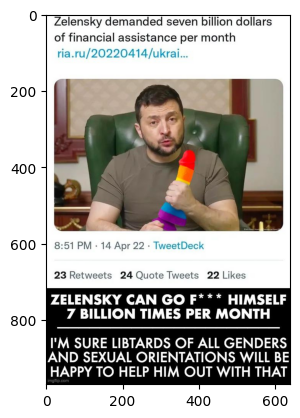

In [8]:
images = os.listdir(HateSpeech)
idx = random.randint(0,len(images))
img_path = os.path.join(HateSpeech,images[idx])
img = Image.open(img_path)
img = np.array(img)
plt.imshow(img)

text = extract_text(img_path)
print(text)

In [9]:
!pip install transformers

In [10]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased")
text = "Replace me by any text you'd like."
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)


In [11]:
!pip install torch torchvision transformers

In [12]:
!pip install sentencepiece

In [13]:
xlnet = transformers.XLNetModel.from_pretrained("xlnet-base-cased")
xlnet.vocab_size = 512
for param in xlnet.parameters():
    param.requires_grad = False

bert = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
bert.vocab_size = 512
for param in bert.parameters():
    param.requires_grad = False

In [14]:
xlnet_tokenizer = transformers.XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

In [16]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
])

In [18]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, texts, labels, transform=None,
                 xlnet_tokenizer=None,bert_tokenizer=None,max_len=1024):
      self.image_paths = image_paths
      self.labels = labels
      self.max_len = max_len
      self.bert_tokenizer = bert_tokenizer
      self.xlnet_tokenizer = xlnet_tokenizer
      self.transform=transform

    def __len__(self):
      return len(os.listdir(self.image_paths))

    def __getitem__(self, idx):
      image = Image.open(self.image_paths[idx]).convert('RGB')
      label = self.labels[idx]
      extracted_text = extract_text(self.image_paths[idx])

      if self.transform:
        image = self.transform(image)

      bert_encoding = self.bert_tokenizer.encode_plus(
                                text = extracted_text,
                                add_special_tokens = True,
                                max_length = self.max_token_len,
                                return_token_type_ids = False,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask = True,
                                return_tensors='pt',
                                # is_split_into_words=True
                        )

      xlnet_encoding = self.xlnet_tokenizer.encode_plus(
                                text = extracted_text,
                                add_special_tokens = True,
                                max_length = self.max_token_len,
                                return_token_type_ids = False,
                                padding="max_length",
                                truncation=True,
                                return_attention_mask = True,
                                return_tensors='pt',
                                # is_split_into_words=True
                        )
      return image, label, bert_encoding, xlnet_encoding


In [19]:
class InceptionNetModel(nn.Module):
    def __init__(self, num_classes):
        super(InceptionNetModel, self).__init__()
        self.inceptionnet_model = models.inception_v3(pretrained=True)
        self.inceptionnet_model.fc = nn.Linear(self.inceptionnet_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.inceptionnet_model(x)

In [20]:
class EnsembleModel(nn.Module):
    def __init__(self, image_model, text_model_xlnet, text_model_bert, num_classes):
        super(EnsembleModel, self).__init__()
        self.image_model = image_model
        self.text_model_xlnet = text_model_xlnet
        self.text_model_bert = text_model_bert
        self.fc = nn.Linear(
            image_model.inceptionnet_model.fc.out_features +
            text_model_xlnet.config.hidden_size +
            text_model_bert.config.hidden_size,
            num_classes
        )

    def forward(self, img, txt_xlnet, txt_bert):
        img_feat = self.image_model(img)
        txt_feat_xlnet = self.text_model_xlnet(**txt_xlnet).last_hidden_state.mean(dim=1)
        txt_feat_bert = self.text_model_bert(**txt_bert).last_hidden_state.mean(dim=1)

        combined_feat = torch.cat((img_feat, txt_feat_xlnet, txt_feat_bert), dim=1)
        return self.fc(combined_feat)
